In [2]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

In [3]:
import io
import tarfile
import requests
import rasterio
from rasterio.plot import show
from matplotlib import pyplot
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

In [5]:
%%time
url = "https://services.sentinel-hub.com/api/v1/process"

evalscript = """
    //VERSION=3
    function setup(ds) {
      return {
        input: [{
          bands: ["B02", "B03", "B04","B08","SCL","dataMask"], 
          units: "DN"
        }],
        output: [        
          {id: "B02", bands: 4, sampleType: SampleType.UINT16},
          {id: "B03", bands: 24, sampleType: SampleType.UINT16},
          {id: "B04", bands: 24, sampleType: SampleType.UINT16},
          {id: "B08", bands: 24, sampleType: SampleType.UINT16},
          {id: "NDVI", bands: 24, sampleType: SampleType.UINT16}
        ],
        mosaicking: Mosaicking.ORBIT       
      }
    }

    function validate (sample) {
      if (sample.dataMask!=1) return false;

      var scl = Math.round(sample.SCL);

      if (scl === 3) { // SC_CLOUD_SHADOW
        return false;
      } else if (scl === 9) { // SC_CLOUD_HIGH_PROBA
        return false; 
      } else if (scl === 8) { // SC_CLOUD_MEDIUM_PROBA
        return false;
      } else if (scl === 7) { // SC_CLOUD_LOW_PROBA
        // return false;
      } else if (scl === 10) { // SC_THIN_CIRRUS
        return false;
      } else if (scl === 11) { // SC_SNOW_ICE
        return false;
      } else if (scl === 1) { // SC_SATURATED_DEFECTIVE
        return false;
      } else if (scl === 2) { // SC_DARK_FEATURE_SHADOW
        // return false;
      }
      return true;
    }

    function calculateIndex(a,b)
    {
      if ((a+b)==0) return 0;
      var val = (a-b)/(a+b);
      if (val<0) val = 0;
      //TODO - we might need to return false instead of 0; depends on the output format - a value needs to be designated as "null"
      return val;
    }

    function interpolatedValue(arr)
    {
      //here we define the function on how to define the proper value - e.g. liner interpolation; we will use average 
      if (arr.length==0) return 0;
      if (arr.length==1) return arr[0];
      var sum = 0;
      for (i=0;i<arr.length;i++)
        {sum+=arr[i];}
      return Math.round(sum/arr.length);
    }

    var res_b02 = [];
    var res_b03 = [];
    var res_b04 = [];
    var res_b08 = [];
    var res_ndvi = [];

    function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {

      //Debug part returning "something" if there are no  valid samples (no observations)
      if (!samples.length)
      return {
        B02: [1], 
        B03: [2], 
        B04: [3], 
        B08: [4], 
        NDVI: [5] 
      }

      var interval = 14; //interval length in days
      var startDate = scenes[0].date.getTime();
      var interval_number = 0;

      var int_b02 = [];
      var int_b03 = [];
      var int_b04 = [];
      var int_b08 = [];
      var int_ndvi = [];

      for (var i = 0; i < samples.length; i++) {
        //TODO order should be reversed when we go leastRecent
        if (startDate-scenes[i].date.getTime()>interval*24*3600*1000)
        {
          fillResultArray(interval_number, int_b02, int_b03, int_b04, int_b08)

          //reset values
          int_b02 = [];
          int_b03 = [];
          int_b04 = [];
          int_b08 = [];
          int_ndvi = [];

          startDate = scenes[i].date.getTime();
          interval_number++;
        }

        if (validate(samples[i]))
        {
          int_b02.push(samples[i].B02);
          int_b03.push(samples[i].B03);
          int_b04.push(samples[i].B04);
          int_b08.push(samples[i].B08);
        }

      }

      //execute this for the last interval 
      fillResultArray(interval_number, int_b02, int_b03, int_b04, int_b08);

      return {
        B02: res_b02, 
        B03: res_b03, 
        B04: res_b04, 
        B08: res_b08, 
        NDVI: res_ndvi 
      }
    }

    function fillResultArray(interval_number, int_b02, int_b03, int_b04, int_b08)
    {
      if (int_b02.length==0) res_b02 [interval_number]=0;
      else res_b02 [interval_number]=interpolatedValue(int_b02);
      if (int_b03.length==0) res_b03 [interval_number]=0
      else res_b03 [interval_number]=interpolatedValue(int_b03);
      if (int_b04.length==0) res_b04 [interval_number]=0;
      else res_b04 [interval_number]=interpolatedValue(int_b04);
      if (int_b08.length==0) res_b08 [interval_number]=0;
      else res_b08 [interval_number]=interpolatedValue(int_b08);

      //calculate relevant indices
      //since we are working with INT16 output, we need to take care that the indices are integeres as well, so we are scaling them to the relevant range
      res_ndvi [interval_number] = 65535*calculateIndex(res_b08 [interval_number],res_b04 [interval_number]);
    }
"""

payload = {
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            },
            "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
        },
        "data": [
            {
                "type": "S2L2A",
                "dataFilter": {
                    "timeRange": {
                        "from": "2018-01-01T00:00:00Z",
                        "to": "2018-01-31T23:59:59Z"
                    },
            "mosaickingOrder": "mostRecent",
            "maxCloudCoverage": 100,
            "previewMode": "DETAIL"
                }
            }
        ]
    },
    "output": {
                "width": 512,
                "height": 512,
                "responses": [
                        {
                "identifier": "B02",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B03",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B04",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B08",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "NDVI",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "userdata",
                "format": {
                    "type": "application/json"
                }
            }
        ]
    },
    "evalscript": evalscript,
    "tilingGridId": 0,
    "bucketName": "eox-sentinelhub-batch",
    "resolution": 40.0,
    "description": "Test Loipersbach"
}

headers = {
  'Accept': 'application/tar'
}

response = oauth.request("POST", url, headers=headers, json = payload)

if response.status_code != requests.codes.ok:
    print(response.json()['error'])

CPU times: user 15.3 ms, sys: 1.61 ms, total: 16.9 ms
Wall time: 10.8 s


-rw-r--r-- 0/0     197490 2020-03-09 09:42:19 B02.tif 
-rw-r--r-- 0/0     318377 2020-03-09 09:42:19 B03.tif 
-rw-r--r-- 0/0     321551 2020-03-09 09:42:19 B04.tif 
-rw-r--r-- 0/0     331655 2020-03-09 09:42:20 B08.tif 
-rw-r--r-- 0/0     353276 2020-03-09 09:42:20 NDVI.tif 
-rw-r--r-- 0/0          4 2020-03-09 09:42:20 userdata.json 


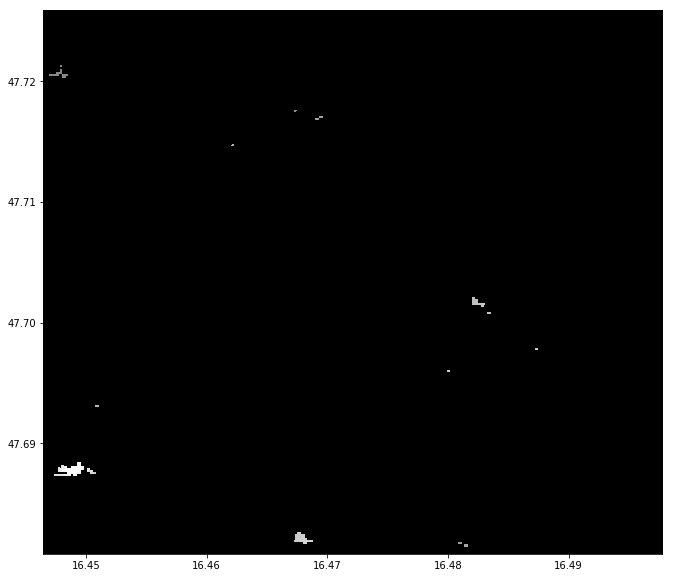

In [28]:
file = io.BytesIO(response.content)
tar = tarfile.open(fileobj=file, mode="r")
tar.list()
tar.extractall('../testing/')#('B04.tif', '../testing/')
with rasterio.open(tar.extractfile('B02.tif')) as tif:
    pyplot.figure(figsize=(16,10))
    show((tif,3), transform=tif.transform, cmap='Greys_r')